In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
import findspark
findspark.init()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from textblob import TextBlob

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import length, when
from pyspark.sql.types import StringType

from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml.classification import NaiveBayes, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [5]:
spark = SparkSession .builder \
  .master("local[*]")\
  .appName("Reviews")\
  .config("spark.memory.fraction", 0.8)\
  .config("spark.executor.memory", "10g")\
  .config("spark.driver.memory", "10g")\
  .config("spark.sql.shuffle.partitions" , "800")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","10g")\
  .getOrCreate()

In [6]:
# Load data
pd_data = pd.read_excel("../../Data/Womens_Clothing_E_Commerce_Reviews.xlsx", sheet_name='Reviews', index_col=0)

In [7]:
pd_data.head(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [8]:
def gen_polarity(sentence):
    blob = TextBlob(str(sentence))
    sentiment_polarity =blob.sentiment.polarity
    return sentiment_polarity

In [9]:
polarity = np.vectorize(gen_polarity)
pd_data['polarity']= polarity(pd_data['Review Text'])

In [10]:
pd_data = pd_data.drop(columns=['Clothing ID', 'Title'])

In [11]:
pd_data = pd_data.dropna()

In [12]:
pd_data.head(5)

,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,polarity
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0.633333
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0.339583
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.073675
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,0.550000
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,0.512891


In [13]:
pd_data['polarity'] =pd_data['polarity'] +1

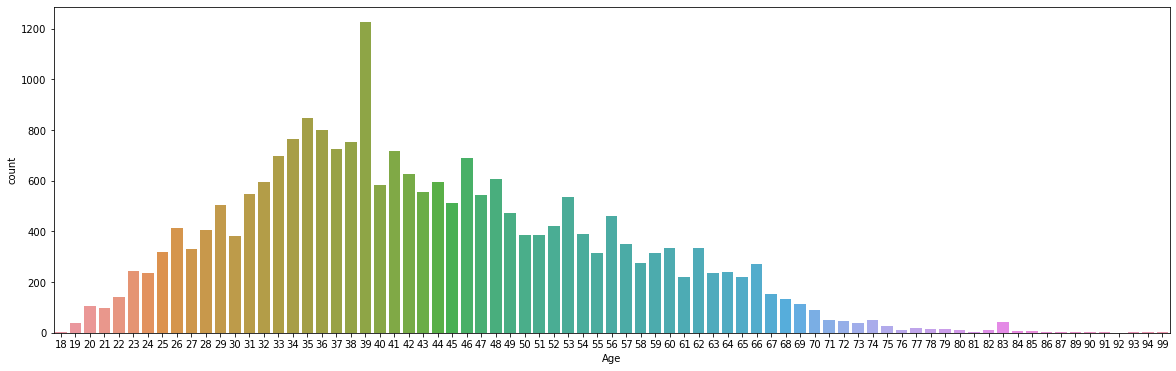

In [14]:
plt.figure(figsize = (20,6))
sns.countplot(x = 'Age', data = pd_data)
plt.show()

### Phần lớn người mua ở độ tuổi 30-50

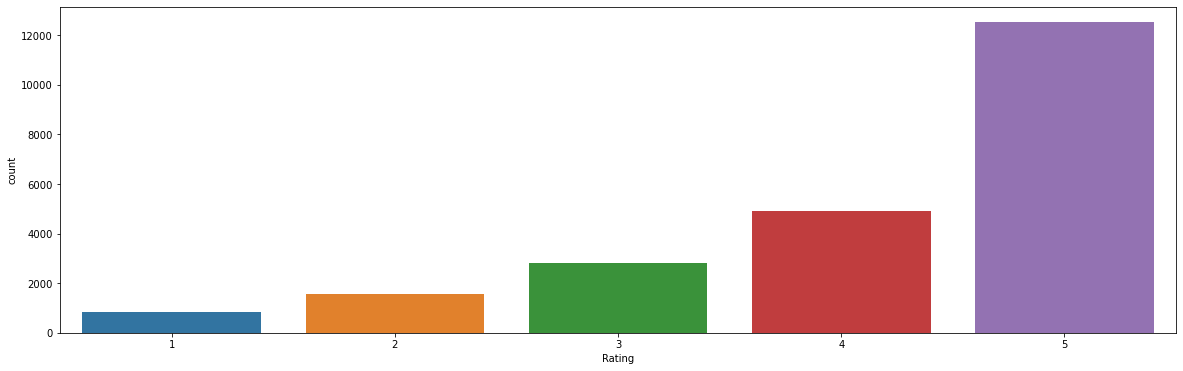

In [15]:
plt.figure(figsize = (20,6))
sns.countplot(x = 'Rating', data = pd_data)
plt.show()

#### Rating 4-5* chiếm đa số => phần lớn các review là tích cực

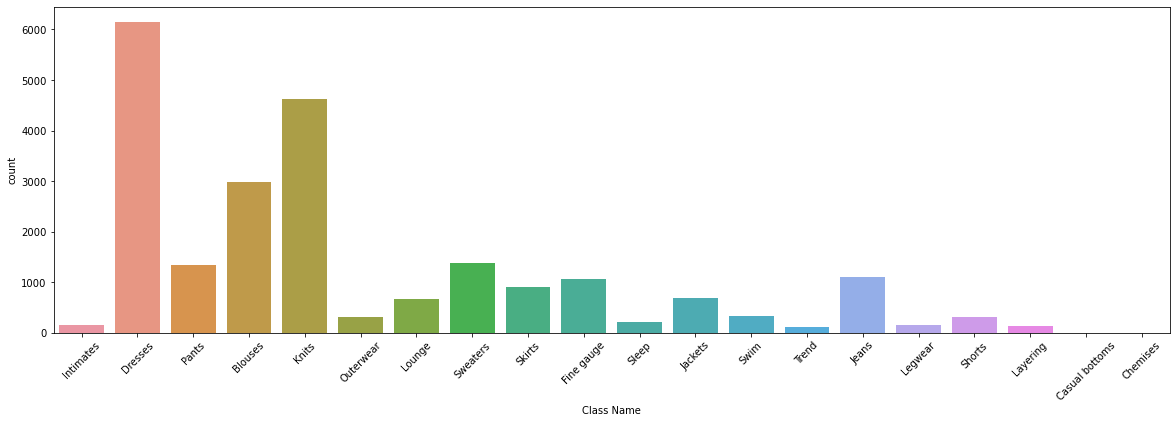

In [16]:
plt.figure(figsize = (20,6))
sns.countplot(x = 'Class Name', data = pd_data)
plt.xticks(rotation = 45)
plt.show()

### Dresses, Knits và Blouses được mua nhiều nhất

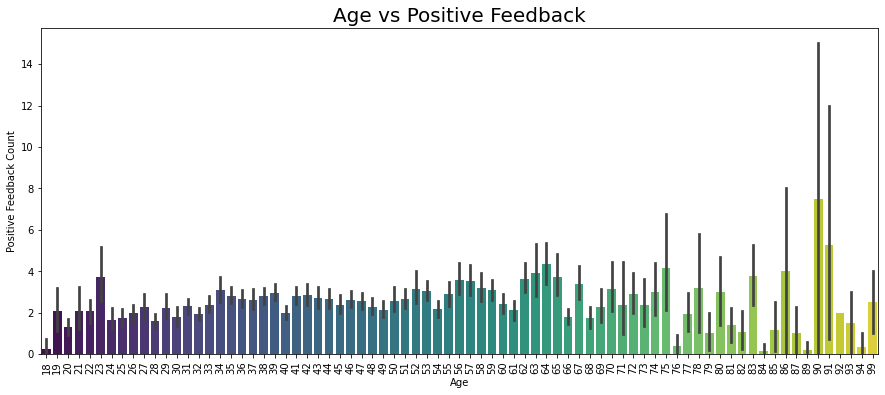

In [17]:
plt.figure(figsize = (15,6))
sns.barplot(x='Age', y='Positive Feedback Count', data=pd_data, palette='viridis')
plt.title('Age vs Positive Feedback', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

### Không có liên hệ nào giữa tuổi và feedback

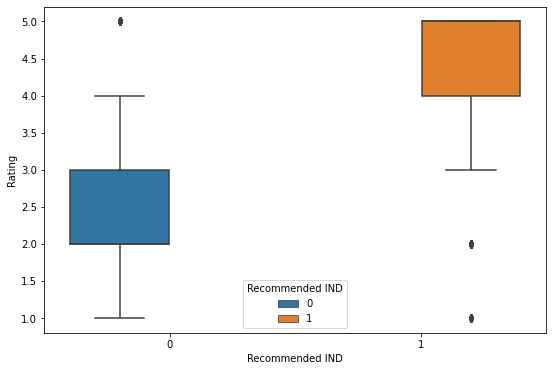

In [18]:
plt.figure(figsize = (9,6))
sns.boxplot(x="Recommended IND", y="Rating", hue = "Recommended IND", data = pd_data)
plt.show()

### Sản phẩm thường được reccomended nếu rating trên 3*

In [19]:
data = spark.createDataFrame(pd_data)

In [20]:
data.show(5)

+---+--------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------+
|Age|         Review Text|Rating|Recommended IND|Positive Feedback Count| Division Name|Department Name|Class Name|          polarity|
+---+--------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------+
| 33|Absolutely wonder...|     4|              1|                      0|     Initmates|       Intimate| Intimates|1.6333333333333333|
| 34|Love this dress! ...|     5|              1|                      4|       General|        Dresses|   Dresses|1.3395833333333333|
| 60|I had such high h...|     3|              0|                      0|       General|        Dresses|   Dresses|1.0736749482401655|
| 50|I love, love, lov...|     5|              1|                      0|General Petite|        Bottoms|     Pants|1.5499999999999998|
| 47|This shirt is ver...|     5|              1|      

In [21]:
data.printSchema()

root
 |-- Age: long (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: long (nullable = true)
 |-- Recommended IND: long (nullable = true)
 |-- Positive Feedback Count: long (nullable = true)
 |-- Division Name: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Class Name: string (nullable = true)
 |-- polarity: double (nullable = true)



In [22]:
data = data.withColumn('length', length(data['Review Text']))

In [23]:
data.show(5)

+---+--------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------+------+
|Age|         Review Text|Rating|Recommended IND|Positive Feedback Count| Division Name|Department Name|Class Name|          polarity|length|
+---+--------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------+------+
| 33|Absolutely wonder...|     4|              1|                      0|     Initmates|       Intimate| Intimates|1.6333333333333333|    53|
| 34|Love this dress! ...|     5|              1|                      4|       General|        Dresses|   Dresses|1.3395833333333333|   303|
| 60|I had such high h...|     3|              0|                      0|       General|        Dresses|   Dresses|1.0736749482401655|   500|
| 50|I love, love, lov...|     5|              1|                      0|General Petite|        Bottoms|     Pants|1.5499999999999998|   124|
| 47|T

In [24]:
data.groupby('Rating').mean().show()

+------+------------------+-----------+--------------------+----------------------------+------------------+------------------+
|Rating|          avg(Age)|avg(Rating)|avg(Recommended IND)|avg(Positive Feedback Count)|     avg(polarity)|       avg(length)|
+------+------------------+-----------+--------------------+----------------------------+------------------+------------------+
|     5|43.697189845122146|        5.0|  0.9981638192559477|          2.4102666453776145|1.3038580989716708| 299.0374421203896|
|     4|43.007540248624416|        4.0|  0.9665783574485429|           2.488485836560016|1.2272344227712855|323.43386998165886|
|     1| 43.72560975609756|        1.0|0.018292682926829267|           3.551219512195122| 1.079958900747568| 305.0365853658537|
|     3| 42.15946137491141|        3.0|  0.4145995747696669|          3.1948972360028347|1.1675860799082263| 328.4156626506024|
|     2| 42.61434108527132|        2.0|0.060723514211886306|           3.356589147286822| 1.123313757055

#### Độ dài review của từng loại ratings không chênh lệch đáng kể

In [25]:
data = data.withColumn('class', when(data.Rating >= 4, 'like').when(data.Rating<= 2, 'not_like').otherwise('neutral'))

In [26]:
stopwords = set(STOPWORDS)

In [27]:
class_to_num = StringIndexer(inputCol='class', outputCol='label')
tokenizer = Tokenizer(inputCol='Review Text', outputCol='token_text')
stopremove = StopWordsRemover(inputCol='token_text', outputCol='stop_tokens', stopWords=list(stopwords))
count_vec = CountVectorizer(inputCol='stop_tokens', outputCol='c_vec')
idf = IDF(inputCol='c_vec', outputCol='tf_idf')
clean_up = VectorAssembler(inputCols=['tf_idf', 'length', 'polarity', 'Recommended IND'], outputCol='features')

In [28]:
data_prep_pipe = Pipeline(stages=[tokenizer, stopremove, count_vec, idf, clean_up, class_to_num])
clearer = data_prep_pipe.fit(data)
clean_data = clearer.transform(data)

In [29]:
clean_data = clean_data.select(['label', 'features'])

In [30]:
clean_data.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(38341,[22,49,137...|
|  0.0|(38341,[0,9,10,12...|
|  1.0|(38341,[1,4,5,7,9...|
|  0.0|(38341,[0,3,6,149...|
|  0.0|(38341,[0,3,23,35...|
|  2.0|(38341,[0,1,3,14,...|
|  0.0|(38341,[2,7,10,13...|
|  0.0|(38341,[5,7,9,14,...|
|  0.0|(38341,[0,9,10,36...|
|  0.0|(38341,[0,1,3,4,8...|
+-----+--------------------+
only showing top 10 rows



In [31]:
(training, testing) = clean_data.randomSplit([0.8, 0.2])

### Naive Bayer

In [32]:
nb = NaiveBayes()

In [33]:
predictor_nb = nb.fit(training)
test_result_nb = predictor_nb.transform(testing)
test_result_nb.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|  564|
|  2.0|       0.0|   56|
|  1.0|       0.0|  122|
|  2.0|       2.0|  252|
|  0.0|       0.0| 2644|
|  0.0|       2.0|  227|
|  1.0|       1.0|  269|
|  2.0|       1.0|  167|
|  1.0|       2.0|  171|
+-----+----------+-----+



In [34]:
acc_eval = MulticlassClassificationEvaluator()

In [35]:
acc_nb = acc_eval.evaluate(test_result_nb)
print("Accuracy of Naive Bayer at predicting was: {}".format(acc_nb))

Accuracy of Naive Bayer at predicting was: 0.7400275458227741


### Logistic Regression

In [36]:
lg = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

In [37]:
predictor_lg = lg.fit(training)
test_result_lg = predictor_lg.transform(testing)
test_result_lg.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|   24|
|  2.0|       0.0|  262|
|  1.0|       0.0|  432|
|  2.0|       2.0|  142|
|  0.0|       0.0| 3404|
|  0.0|       2.0|    7|
|  1.0|       1.0|   84|
|  2.0|       1.0|   71|
|  1.0|       2.0|   46|
+-----+----------+-----+



In [38]:
acc_lg = acc_eval.evaluate(test_result_lg)
print("Accuracy of Logistic Regression model at predicting was: {}".format(acc_lg))

Accuracy of Logistic Regression model at predicting was: 0.7677023495760531


### Random Forest

In [39]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=500, maxDepth=5, maxBins=64)

In [40]:
predictor_rf = rf.fit(training)
test_result_rf = predictor_rf.transform(testing)
test_result_rf.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|  475|
|  1.0|       0.0|  562|
|  0.0|       0.0| 3435|
+-----+----------+-----+



In [41]:
acc_rf = acc_eval.evaluate(test_result_rf)
print("Accuracy of model at predicting was: {}".format(acc_rf))

Accuracy of model at predicting was: 0.6673750167703126


### Độ chính xác khá tệ

# Dự đoán dữ liệu mới

In [42]:
new_data = pd.read_excel("../../Data/Womens_Clothing_E_Commerce_Reviews.xlsx", sheet_name='new_reviews', index_col=0)

In [43]:
new_data

,Clothing ID,Age,Title,Review Text,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,53,Dress looks like it's made of cheap material,Dress runs small esp where the zipper area run...,0,14,General,Dresses,Dresses
1,862,66,Cute top,Nice top. armholes are a bit oversized but as ...,1,2,General,Tops,Knits
2,1080,31,Underwhelmed,Was really excited for this dress but should h...,0,1,General,Dresses,Dresses
3,936,35,Absolutely perfect,If you are going for a ridiculously high price...,0,9,General,Tops,Sweaters
4,872,35,Cute comfy casual,I saw this online and immediately purchased th...,1,0,General,Tops,Knits


In [44]:
new_data['polarity'] = polarity(new_data['Review Text'])
new_data['polarity'] = new_data['polarity'] + 1
input_data = spark.createDataFrame(new_data)

In [45]:
input_data = input_data.withColumn('length', length(input_data['Review Text']))

In [46]:
test_prep_pipe = Pipeline(stages=[tokenizer, stopremove, count_vec, idf, clean_up])
new_input = test_prep_pipe.fit(input_data)
new_clean = new_input.transform(input_data)

In [47]:
new_clean = new_clean.select(['Review Text','features'])

In [48]:
new_result_nb = predictor_nb.transform(new_clean)

In [49]:
new_result_nb.select(['features']).show()

+--------------------+
|            features|
+--------------------+
|(149,[0,1,2,4,5,7...|
|(149,[3,5,6,13,22...|
|(149,[1,2,7,9,10,...|
|(149,[0,6,8,11,12...|
|(149,[4,9,25,29,3...|
+--------------------+



In [50]:
new_result_lg = predictor_lg.transform(new_clean)

In [51]:
new_result_lg.select(['prediction']).show()

Py4JJavaError: An error occurred while calling o1020.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 141.0 failed 1 times, most recent failure: Lost task 3.0 in stage 141.0 (TID 4798) (HiepPC.mshome.net executor driver): org.apache.spark.SparkException: Failed to execute user defined function(ProbabilisticClassificationModel$$Lambda$3826/1257411109: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:345)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: The columns of A don't match the number of elements of x. A: 38341, x: 149
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.gemv(BLAS.scala:551)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margins$1(LogisticRegression.scala:1105)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1211)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:998)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(ProbabilisticClassificationModel$$Lambda$3826/1257411109: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:345)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.IllegalArgumentException: requirement failed: The columns of A don't match the number of elements of x. A: 38341, x: 149
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.gemv(BLAS.scala:551)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margins$1(LogisticRegression.scala:1105)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1211)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:998)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 17 more
